In [1]:
import pandas as pd
import sklearn
import numpy as np


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [16]:
pd.set_option("display.max_columns", 100)

In [13]:
from sklearn.base import TransformerMixin, BaseEstimator

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        
        self.key = key
        

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


Import the trimmed txn dataset - Removed columns that are predominanetly empty or have zero values

In [28]:
transactions_df = pd.read_csv('trimmed_transaction_dataset.csv')

In [29]:
transactions_df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,6.0,27.0,StatusNetwork,EOS


In [30]:
transactions_df[' ERC20_most_rec_token_type'] = transactions_df[' ERC20_most_rec_token_type'].astype(str)

In [31]:
y = transactions_df.pop('FLAG')

In [32]:
X = transactions_df

In [33]:
X_set, X_test, y_set, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_set, y_set, stratify=y_set, test_size=0.10, random_state=42)

In [35]:
print(len(X_train), len(X_test))

6465 1797


In [36]:
y_train.value_counts()

0    5493
1     972
Name: FLAG, dtype: int64

In [37]:
y_test.value_counts()

0    1527
1     270
Name: FLAG, dtype: int64

In [38]:
y_val.value_counts()

0    611
1    108
Name: FLAG, dtype: int64

In [61]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('ngram_text', Pipeline([
            ('selector', ItemSelector(key=' ERC20_most_rec_token_type')),
            ('vectorizer', CountVectorizer(ngram_range=(1,3), lowercase=True))
            #('tfidf_transformer',  TfidfVectorizer(ngram_range=(1, 8)))
        ]))
    ],
    
    )),
    #('classifier',  DecisionTreeClassifier(max_depth=256, criterion="entropy")) ])
    #('classifier',  LinearSVC(C=0.1, verbose = 2, max_iter=2000)) ])
    #('classifier', MultinomialNB(alpha=0.1))])
    #('classifier', GaussianNB())])
   # ('classifier',  LogisticRegression()) ])
    ('classifier',  RandomForestClassifier()) ])
    #('classifier', DecisionTreeClassifier(max_depth=8)) ])
    #('classifier',  SVC(kernel='linear', gamma=0.1)) ])

In [75]:
def createPipeline(column_name, classifier):
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('ngram_text', Pipeline([
                ('selector', ItemSelector(key=column_name)),
                ('vectorizer', CountVectorizer(ngram_range=(1,3), lowercase=True))
                #('tfidf_transformer',  TfidfVectorizer(ngram_range=(1, 8)))
            ]))
        ],
        
        )),
        #('classifier',  DecisionTreeClassifier(max_depth=256, criterion="entropy")) ])
        #('classifier',  LinearSVC(C=0.1, verbose = 2, max_iter=2000)) ])
        #('classifier', MultinomialNB(alpha=0.1))])
        #('classifier', GaussianNB())])
        ('classifier',  classifier) ])
        #('classifier',  RandomForestClassifier()) ])
        #('classifier', DecisionTreeClassifier(max_depth=8)) ])
        #('classifier',  SVC(kernel='linear', gamma=0.1)) ])
    return pipeline

In [84]:
log_reg_pipe = createPipeline(' ERC20_most_rec_token_type', LogisticRegression())
forest_pipe = createPipeline(' ERC20_most_rec_token_type', RandomForestClassifier())
linearsvc_pipe = createPipeline(' ERC20_most_rec_token_type', LinearSVC())
baseline_pipe = createPipeline(' ERC20_most_rec_token_type', DummyClassifier(strategy='most_frequent', random_state=0))


In [85]:
models = [('LR',log_reg_pipe), ('RF',forest_pipe), ('LSVC',linearsvc_pipe), ('BASE',baseline_pipe)]

In [96]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'f1']
results = []
names = []
target_names = ['0', '1']
dfs = []

In [97]:
for name, model in models:
    skfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=45)
    cv_results = model_selection.cross_validate(model, X_set, y_set, cv=skfold, scoring=scoring)
    clf = model.fit(X_set, y_set)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)

    
final = pd.concat(dfs, ignore_index=True)

LR
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1527
           1       0.98      0.75      0.85       270

    accuracy                           0.96      1797
   macro avg       0.97      0.87      0.91      1797
weighted avg       0.96      0.96      0.96      1797

RF
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1527
           1       0.94      0.79      0.86       270

    accuracy                           0.96      1797
   macro avg       0.95      0.89      0.92      1797
weighted avg       0.96      0.96      0.96      1797

LSVC
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1527
           1       0.96      0.79      0.87       270

    accuracy                           0.96      1797
   macro avg       0.96      0.89      0.92      1797
weighted avg       0.96      0.96      0.96      1797



/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/met

BASE
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1527
           1       0.00      0.00      0.00       270

    accuracy                           0.85      1797
   macro avg       0.42      0.50      0.46      1797
weighted avg       0.72      0.85      0.78      1797



/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
final.head()

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,test_f1,model
0,0.080373,0.021825,0.947112,0.947955,0.947112,0.943521,0.929610,0.808081,LR
1,0.057414,0.018404,0.943633,0.944353,0.943633,0.939614,0.925490,0.794937,LR
2,0.056308,0.020889,0.963118,0.963413,0.963118,0.960906,0.949907,0.837920,LR
3,0.056877,0.018768,0.958246,0.959547,0.958246,0.955671,0.908402,0.843750,LR
4,0.055414,0.016688,0.957521,0.957986,0.957521,0.955066,0.937553,0.837333,LR


In [99]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')

In [100]:
time_metrics = ['fit_time','score_time'] # fit time metrics

results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

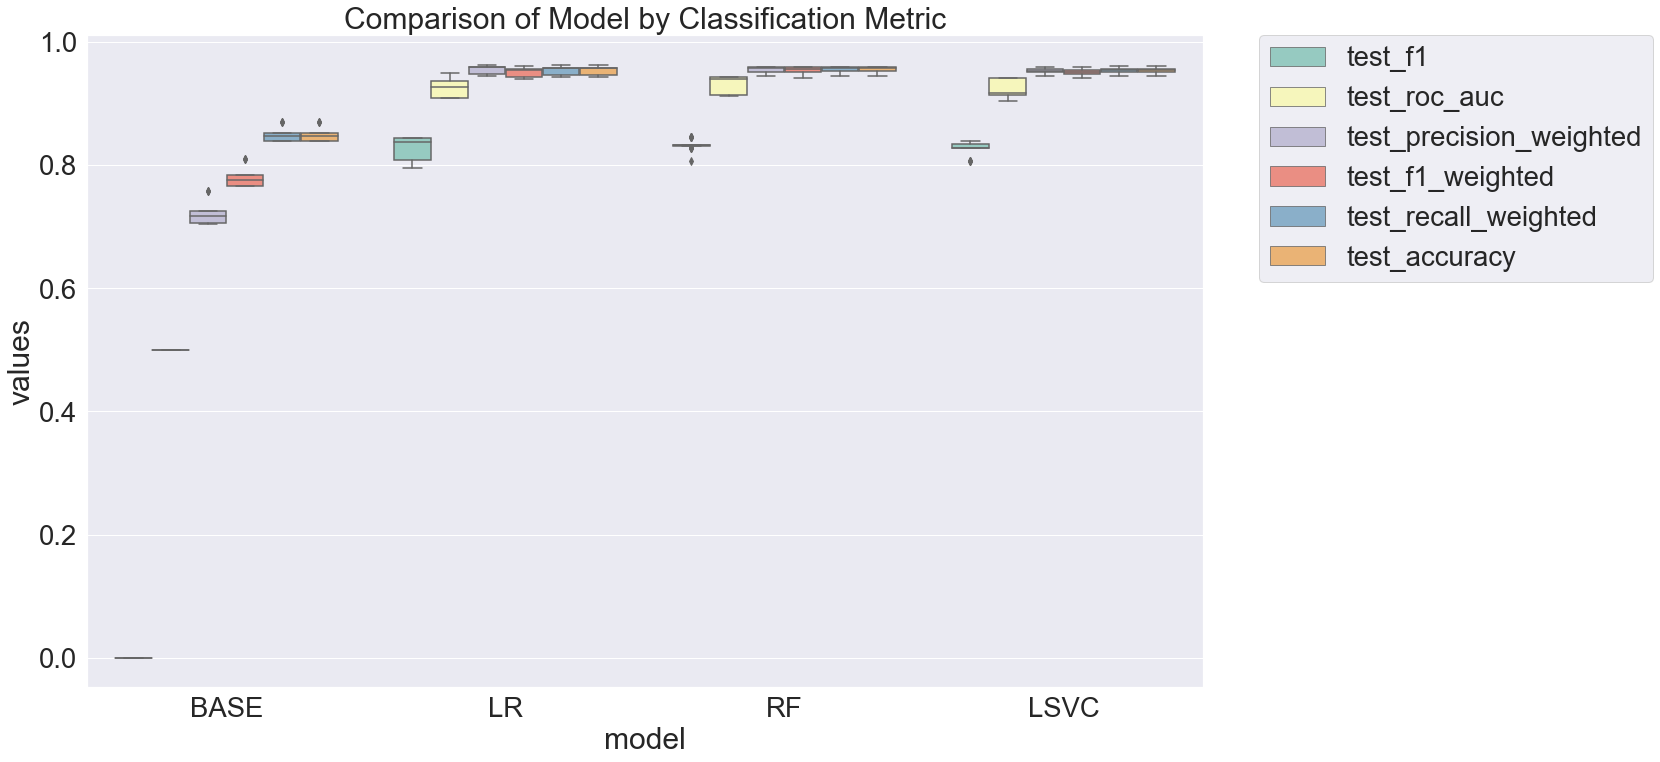

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

In [105]:
def evaluateTestSet(x_train, x_test, y_train, y_test, model):
    clf = model.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test,y_pred))  

In [106]:
evaluateTestSet(X_set, X_test, y_set, y_test, forest_pipe)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1527
           1       0.94      0.79      0.86       270

    accuracy                           0.96      1797
   macro avg       0.95      0.89      0.92      1797
weighted avg       0.96      0.96      0.96      1797

[[1514   13]
 [  56  214]]


In [107]:
evaluateTestSet(X_set, X_test, y_set, y_test, linearsvc_pipe)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1527
           1       0.96      0.79      0.87       270

    accuracy                           0.96      1797
   macro avg       0.96      0.89      0.92      1797
weighted avg       0.96      0.96      0.96      1797

[[1518    9]
 [  56  214]]
